**1. Reading the Data**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
!pip install feature_engine
from feature_engine.outliers import Winsorizer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import RandomSampleImputer

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import kurtosis, skew

import itertools

from warnings import simplefilter
simplefilter("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 12.8 MB/s eta 0:00:00


In [3]:
data = pd.read_csv("/content/water_potability.csv")

data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

The dataset has 3276 rows and 10 columns.


In [5]:
print(f'The dataset has {data.isna().sum().sum()} null values.')

The dataset has 1434 null values.


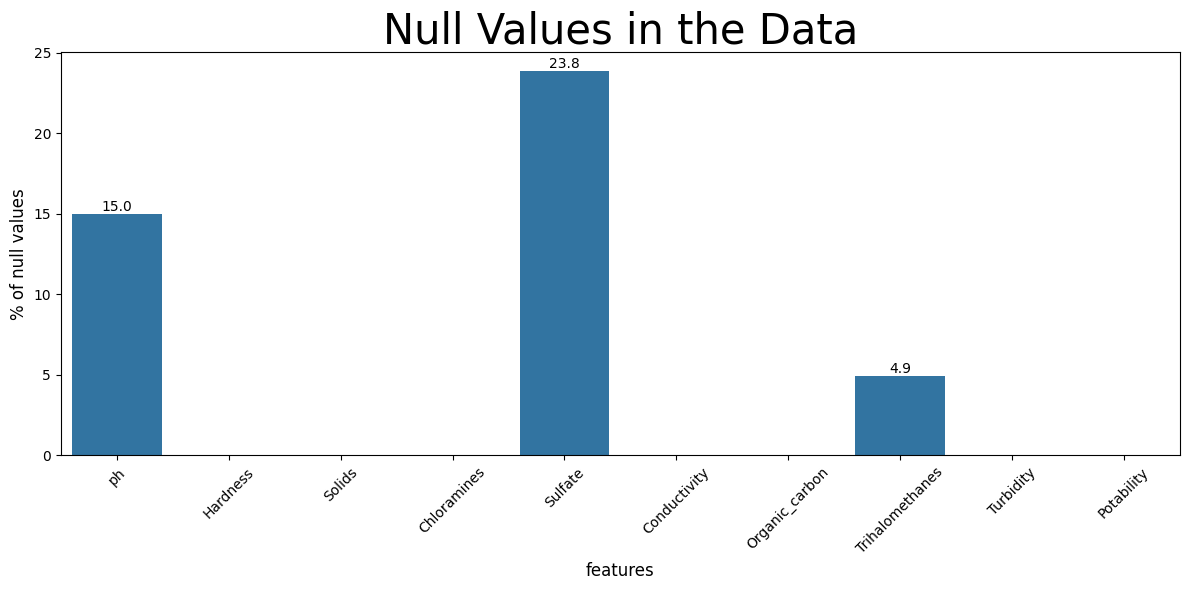

In [6]:
data_nulls = (data.apply(lambda x: x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name='count')


fig = plt.figure(figsize=(12,6))

fig = sns.barplot(data_nulls, x="index", y="count")
fig.set_title('Null Values in the Data', fontsize=30)
fig.set_xlabel('features', fontsize=12)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.set_ylabel('% of null values', fontsize=12)
fig.bar_label(fig.containers[0], fmt='%.1f')

plt.tight_layout()

There are three columns out of ten which contains null values.

In [7]:
print(f'There are {data.duplicated().sum()} duplicate rows in the data.')

There are 0 duplicate rows in the data.


In [8]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


**2. Exploratory Data Analysis**

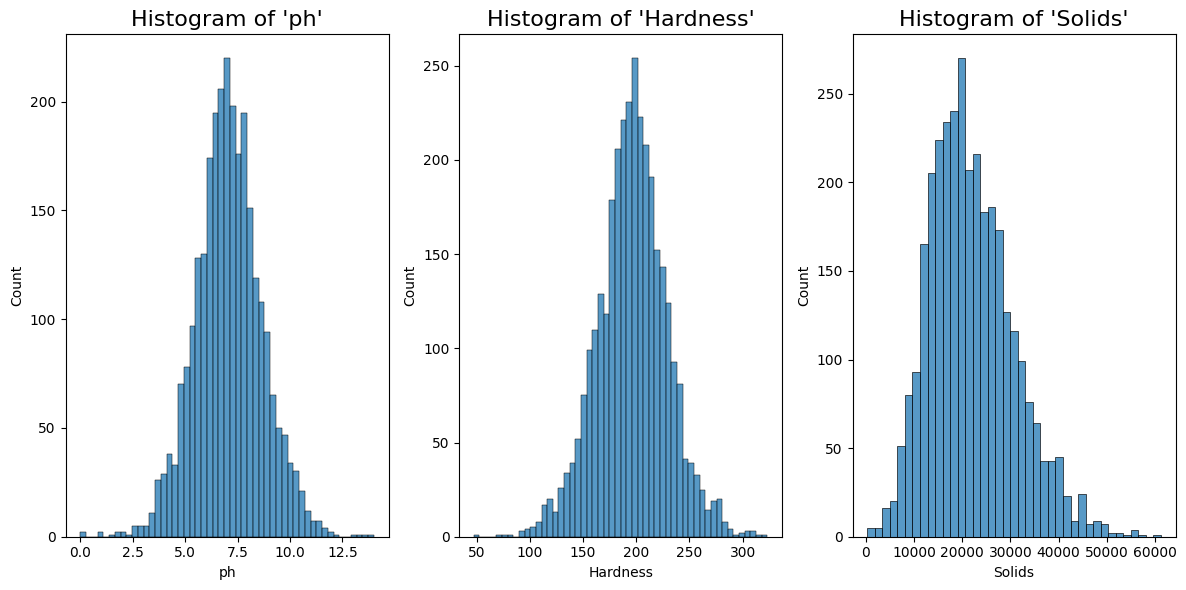

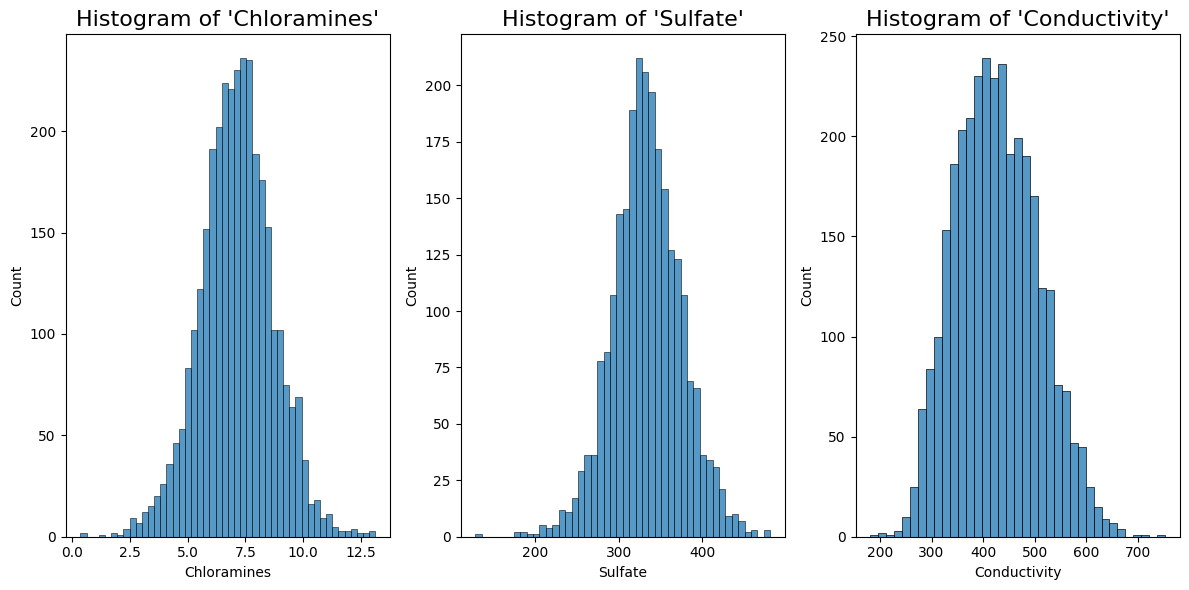

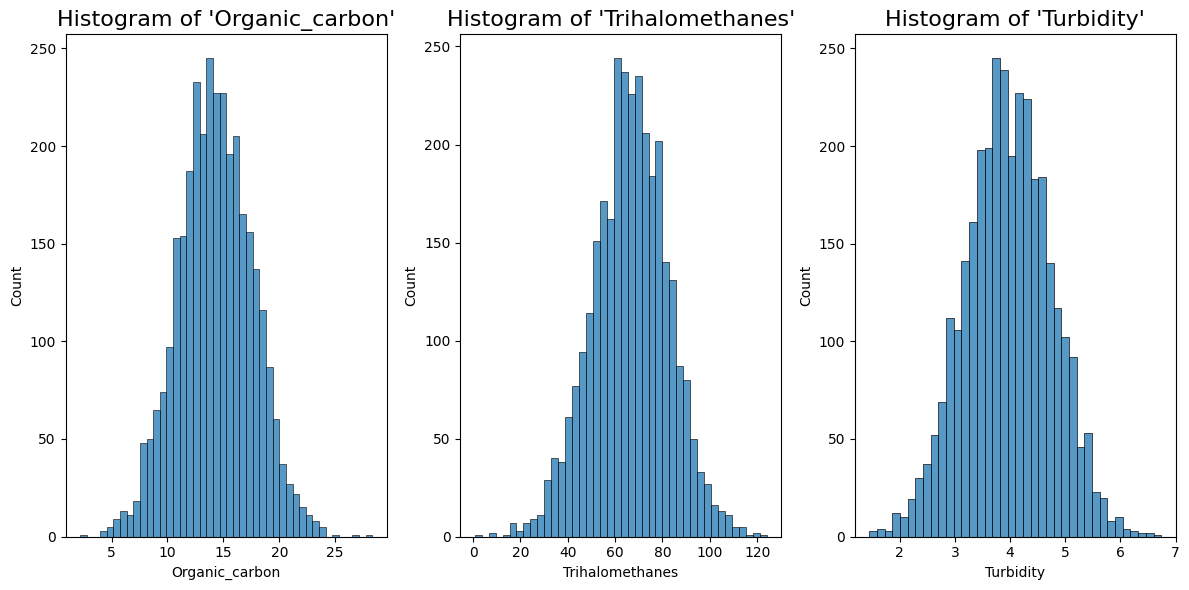

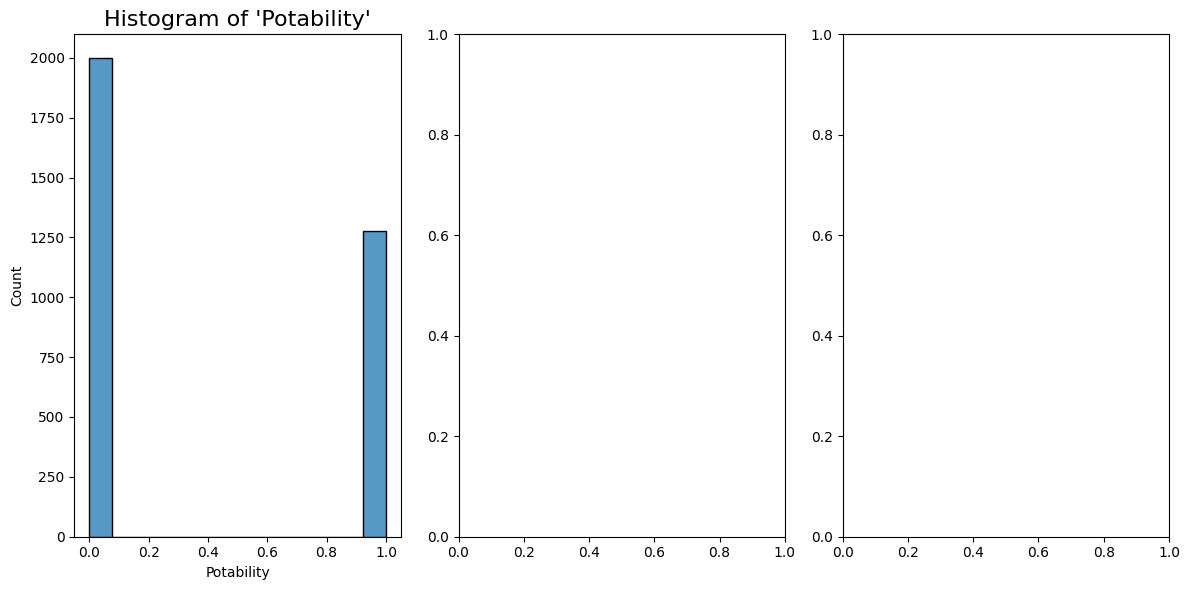

In [9]:
cols = data.columns


for i in range (4):

    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,6))

    ax1 = sns.histplot(data[cols[i*3]], ax=ax1)
    ax1.set_title(f"Histogram of '{cols[i*3]}'", size=16)

    if i < 3:
        ax2 = sns.histplot(data[cols[i*3+1]], ax=ax2)
        ax2.set_title(f"Histogram of '{cols[i*3+1]}'", size=16)
        ax3 = sns.histplot(data[cols[i*3+2]], ax=ax3)
        ax3.set_title(f"Histogram of '{cols[i*3+2]}'", size=16)

    plt.tight_layout()

In [10]:
predictors = [col for col in data.columns if col != 'Potability']

for col in predictors:
    print(f"Skewness of '{col}: {skew(data[~data[col].isna()][col])}")
    print(f"Kurtosis of '{col}: {kurtosis(data[~data[col].isna()][col])}")
    print()

Skewness of 'ph: 0.025616641016486575
Kurtosis of 'ph: 0.7168693987691377

Skewness of 'Hardness: -0.0393236888840398
Kurtosis of 'Hardness: 0.6130013182749212

Skewness of 'Solids: 0.6213498181329244
Kurtosis of 'Solids: 0.44031956762263125

Skewness of 'Chloramines: -0.012092899840854208
Kurtosis of 'Chloramines: 0.5871702727436974

Skewness of 'Sulfate: -0.035925006801605895
Kurtosis of 'Sulfate: 0.6445605737219453

Skewness of 'Conductivity: 0.2643691049378588
Kurtosis of 'Conductivity: -0.27850104314580815

Skewness of 'Organic_carbon: 0.025520889860291555
Kurtosis of 'Organic_carbon: 0.042510613396353314

Skewness of 'Trihalomethanes: -0.08299067321849515
Kurtosis of 'Trihalomethanes: 0.23628834425058365

Skewness of 'Turbidity: -0.007813062873377002
Kurtosis of 'Turbidity: -0.06453577483679762



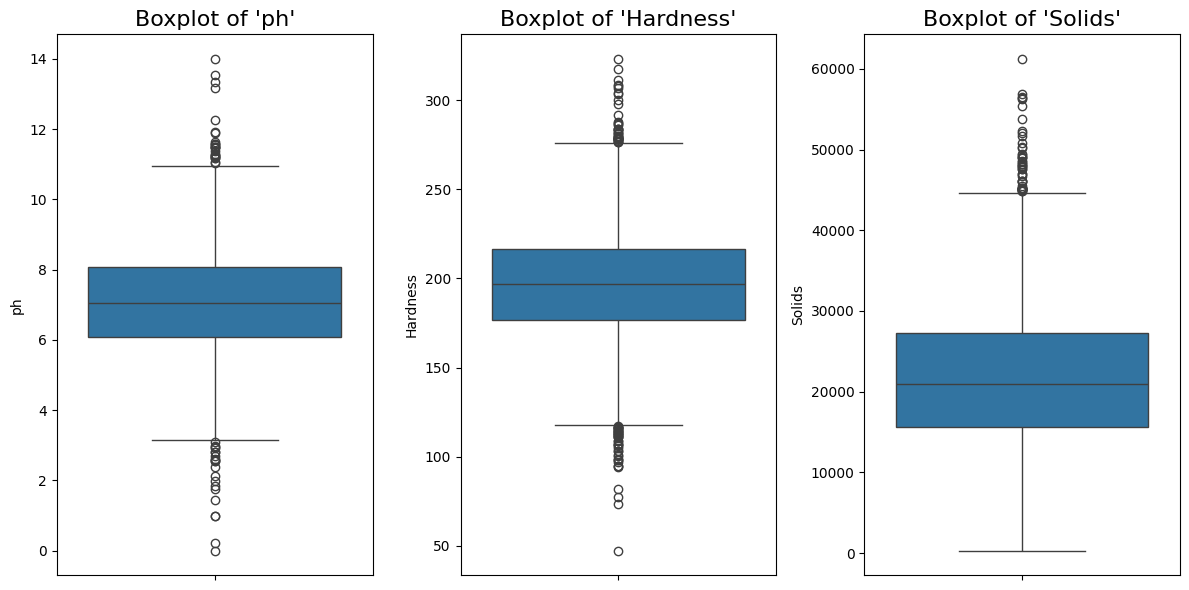

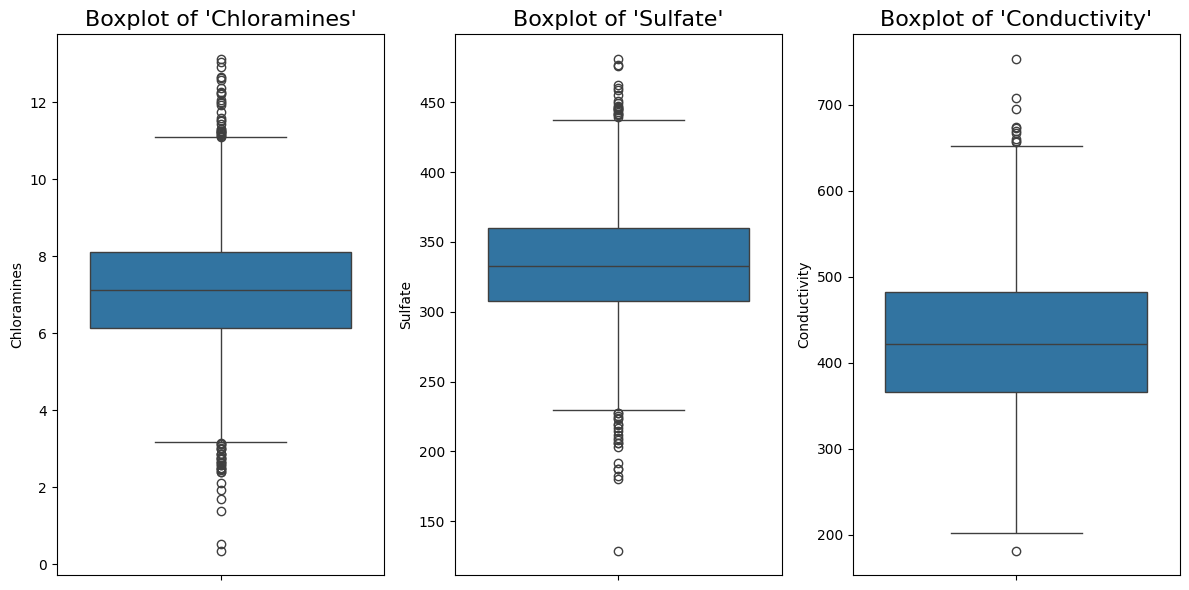

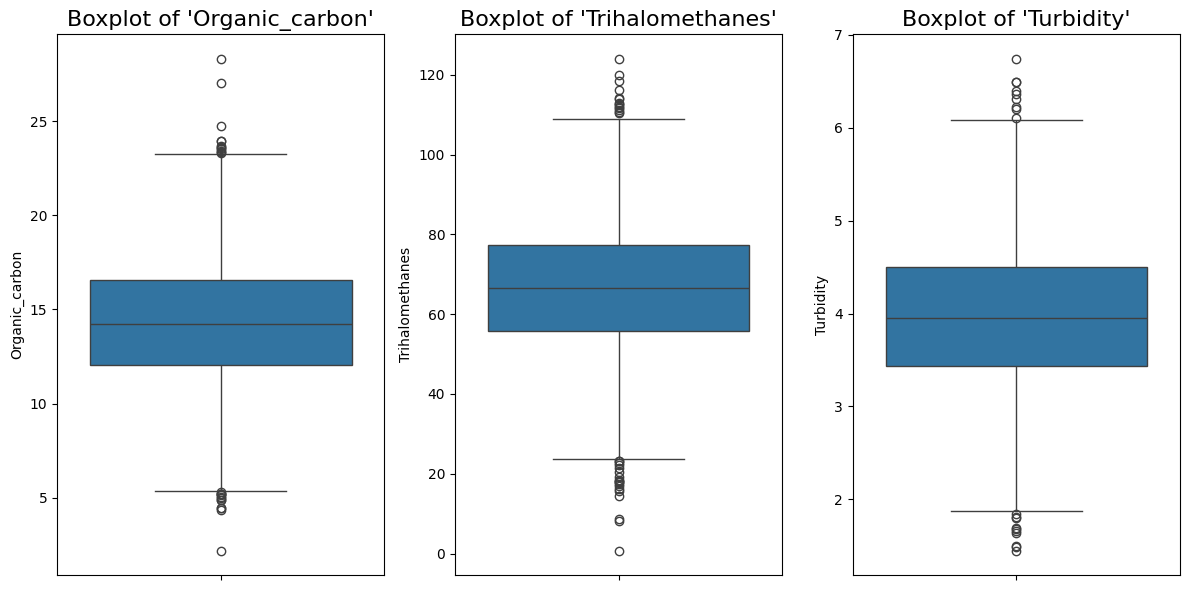

In [11]:
for i in range (3):

    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,6))

    ax1 = sns.boxplot(data[cols[i*3]], ax=ax1)
    ax1.set_title(f"Boxplot of '{cols[i*3]}'", size=16)

    ax2 = sns.boxplot(data[cols[i*3+1]], ax=ax2)
    ax2.set_title(f"Boxplot of '{cols[i*3+1]}'", size=16)

    ax3 = sns.boxplot(data[cols[i*3+2]], ax=ax3)
    ax3.set_title(f"Boxplot of '{cols[i*3+2]}'", size=16)

    plt.tight_layout()

In [12]:
print('### Percentage of outliers in the columns ###')
print()

def calculate_outlier_percentage(dataframe, column):
    if dataframe[column].dtype != 'object':
        q1 = dataframe[column].quantile(0.25)
        q3 = dataframe[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        perc = (len(outliers) / len(dataframe)) * 100
        return column, perc
    return column, None

outliers_perc = []
for col in predictors:
    col_name, percentage = calculate_outlier_percentage(data, col)
    if percentage is not None:
        outliers_perc.append((col_name, int(percentage)))
        print(f"Column {col_name} outliers = {percentage:.1f}%")

### Percentage of outliers in the columns ###

Column ph outliers = 1.4%
Column Hardness outliers = 2.5%
Column Solids outliers = 1.4%
Column Chloramines outliers = 1.9%
Column Sulfate outliers = 1.3%
Column Conductivity outliers = 0.3%
Column Organic_carbon outliers = 0.8%
Column Trihalomethanes outliers = 1.0%
Column Turbidity outliers = 0.6%


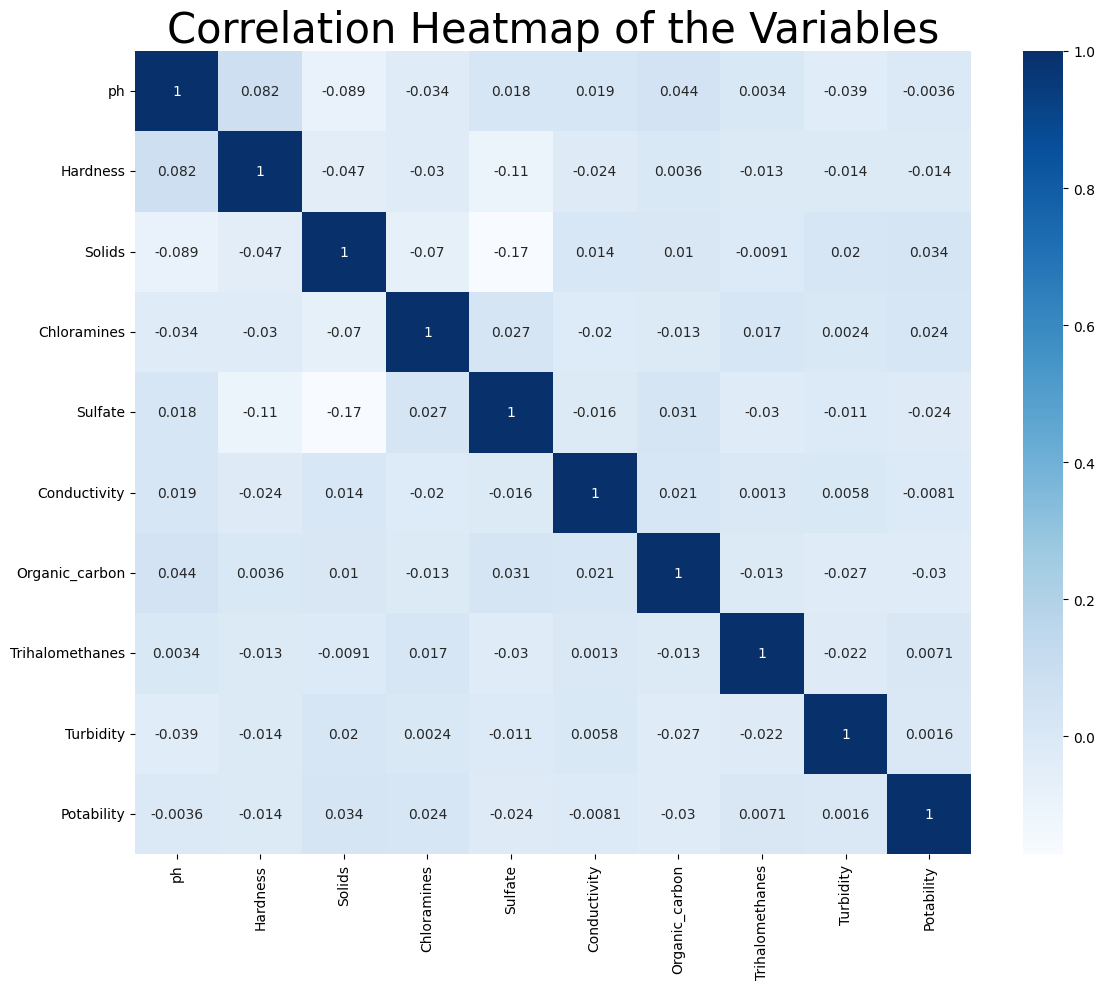

In [13]:
fig = plt.figure(figsize=(12,10))

fig = sns.heatmap(data.corr(), annot=True, cmap='Blues')
fig.set_title('Correlation Heatmap of the Variables', size=30)

plt.tight_layout()

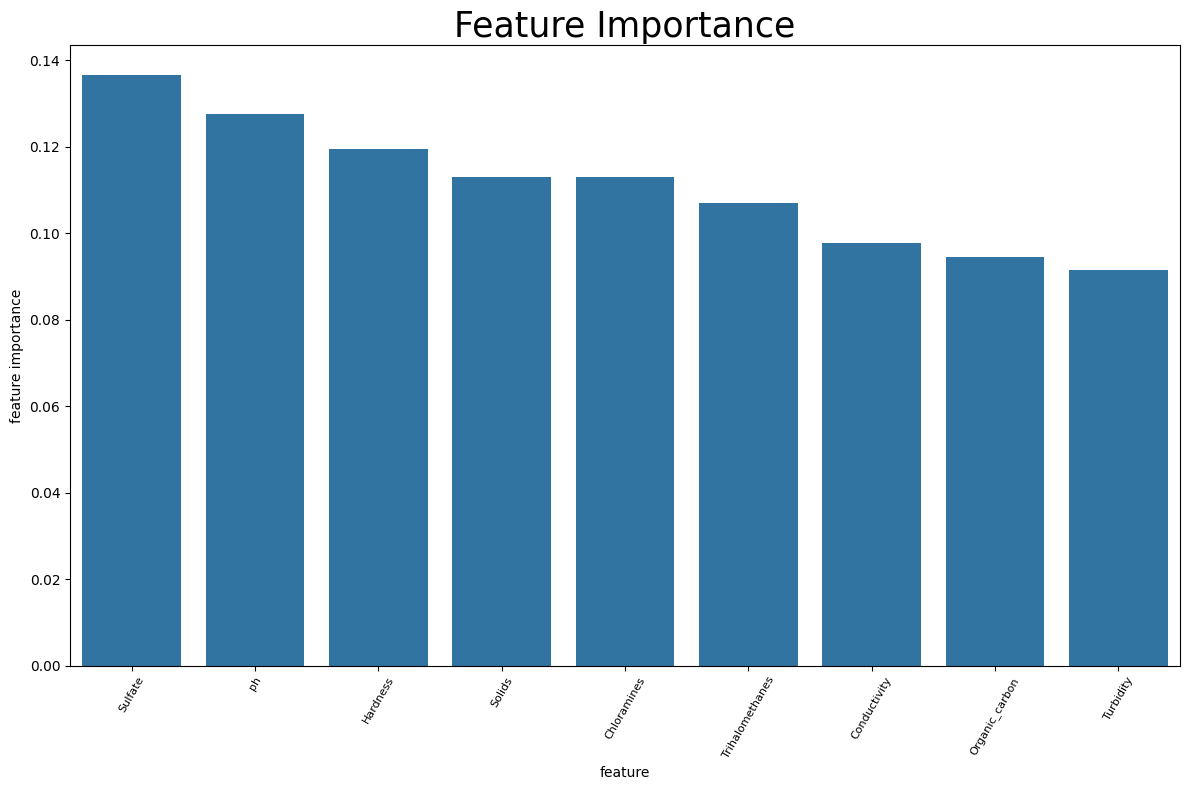

In [14]:
# Random Forest Model
rf = RandomForestClassifier(n_estimators=100)

X = data.drop('Potability', axis=1)
y = data['Potability']

rf.fit(X, y)

sorted_idx = (-rf.feature_importances_).argsort()

list_of_tuples = list(zip(X.columns[sorted_idx],
                          rf.feature_importances_[sorted_idx]))

feat_importance = pd.DataFrame(list_of_tuples,
                  columns=['feature', 'feature importance'])

fig = plt.figure(figsize=(12,8))

fig = sns.barplot(data=feat_importance, x='feature', y='feature importance')
plt.title('Feature Importance',fontsize=25)
plt.xticks(fontsize=8,rotation=60)

plt.tight_layout()


In [15]:
perm_importance = permutation_importance(rf, X, y)

sorted_idx = (-perm_importance.importances_mean).argsort()

list_of_tuples  = list(zip(X.columns[sorted_idx],
                           perm_importance.importances_mean[sorted_idx]))

perm_importance = pd.DataFrame(list_of_tuples,
                  columns=['feature','permutation importance'])

print(perm_importance.head())

       feature  permutation importance
0           ph                0.167216
1      Sulfate                0.160256
2     Hardness                0.086386
3  Chloramines                0.060317
4       Solids                0.056471


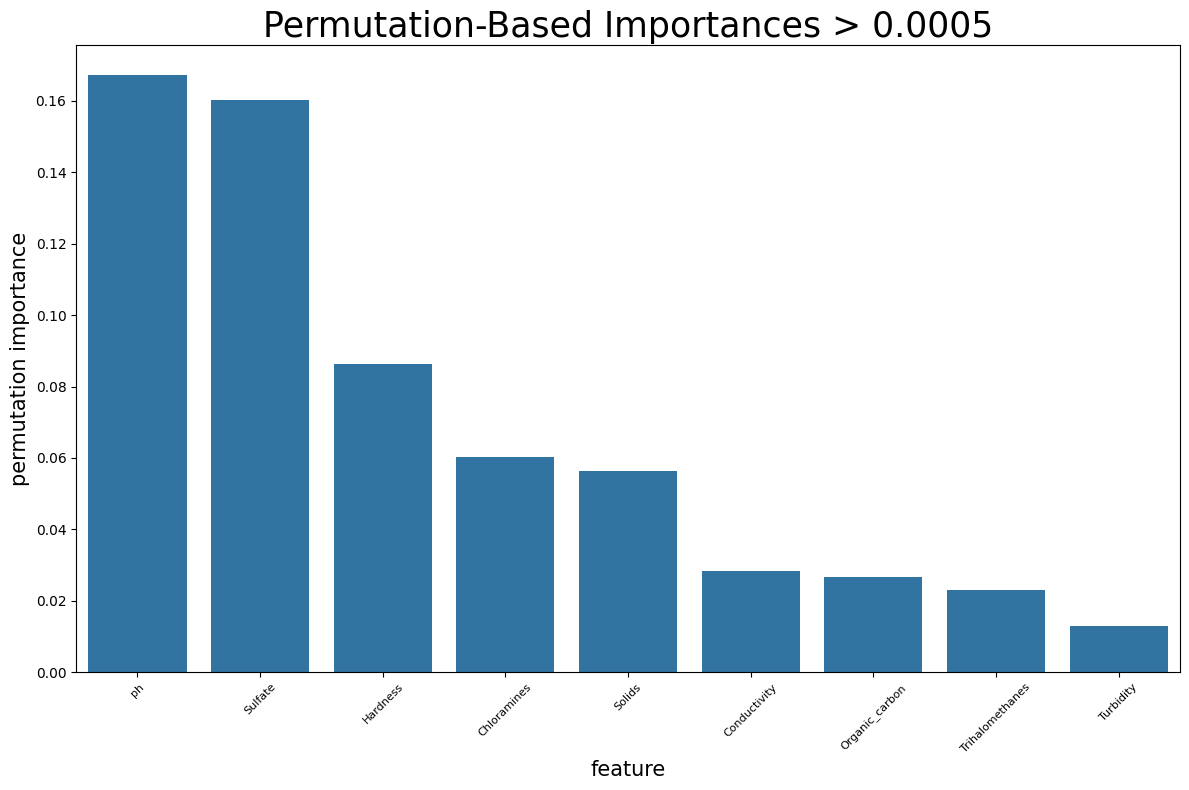

In [16]:
plt.figure(figsize=(12,8))

sns.barplot(perm_importance[perm_importance['permutation importance'] > 0.0005], x='feature', y='permutation importance')

plt.title('Permutation-Based Importances > 0.0005', fontsize=25)
plt.xlabel('feature', fontsize=15)
plt.xticks(fontsize=8, rotation=45)
plt.ylabel('permutation importance', fontsize=15)

plt.tight_layout()

**3. Feature Engineering**

In [17]:
X1 = X.copy()

imputer1 = Pipeline([
    ("mean_imputer", MeanMedianImputer(imputation_method="mean"))
])

imputer1.fit(X1)

X1 = imputer1.transform(X1)

X1.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075


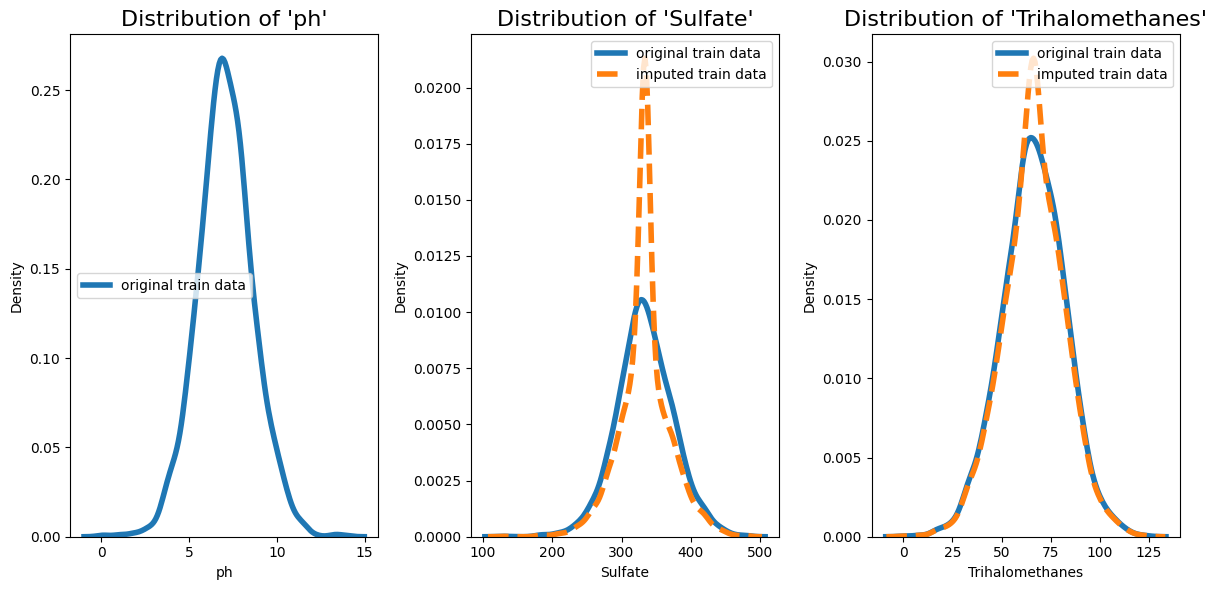

In [18]:
null_cols = ['ph','Sulfate','Trihalomethanes']


def plot_nulls(X, X1):

    fig, axes = plt.subplots(ncols=3, figsize=(12,6))

    axes[0] = sns.kdeplot(X[null_cols[0]], linewidth=4, label='original train data', ax=axes[0])
    axes[0].set_title(f"Distribution of '{null_cols[0]}'", size=16)
    axes[0].legend()

    axes[1] = sns.kdeplot(X[null_cols[1]], linewidth=4, label='original train data', ax=axes[1])
    axes[1] = sns.kdeplot(X1[null_cols[1]], linewidth=4, linestyle='--', label='imputed train data', ax=axes[1])
    axes[1].set_title(f"Distribution of '{null_cols[1]}'", size=16)
    axes[1].legend()

    axes[2] = sns.kdeplot(X[null_cols[2]], linewidth=4, label='original train data', ax=axes[2])
    axes[2] = sns.kdeplot(X1[null_cols[2]], linewidth=4, linestyle='--', label='imputed train data', ax=axes[2])
    axes[2].set_title(f"Distribution of '{null_cols[2]}'", size=16)
    axes[2].legend()

    plt.tight_layout()


plot_nulls(X, X1)

In [19]:
X2 = X.copy()

imputer2 = ColumnTransformer(
    transformers=[
        ("random_imputer", RandomSampleImputer(random_state=42), predictors)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

imputer2.fit_transform(X2)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,9.319176,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,255.976746,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,322.750328,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075
...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821
3272,7.808856,193.553212,17329.802160,8.061362,298.082462,392.449580,19.903225,75.934052,2.798243
3273,9.419510,175.762646,33155.578218,7.350233,394.092424,432.044783,11.039070,69.845400,3.298875
3274,5.126763,230.603758,11983.869376,6.303357,325.906562,402.883113,11.168946,77.488213,4.708658


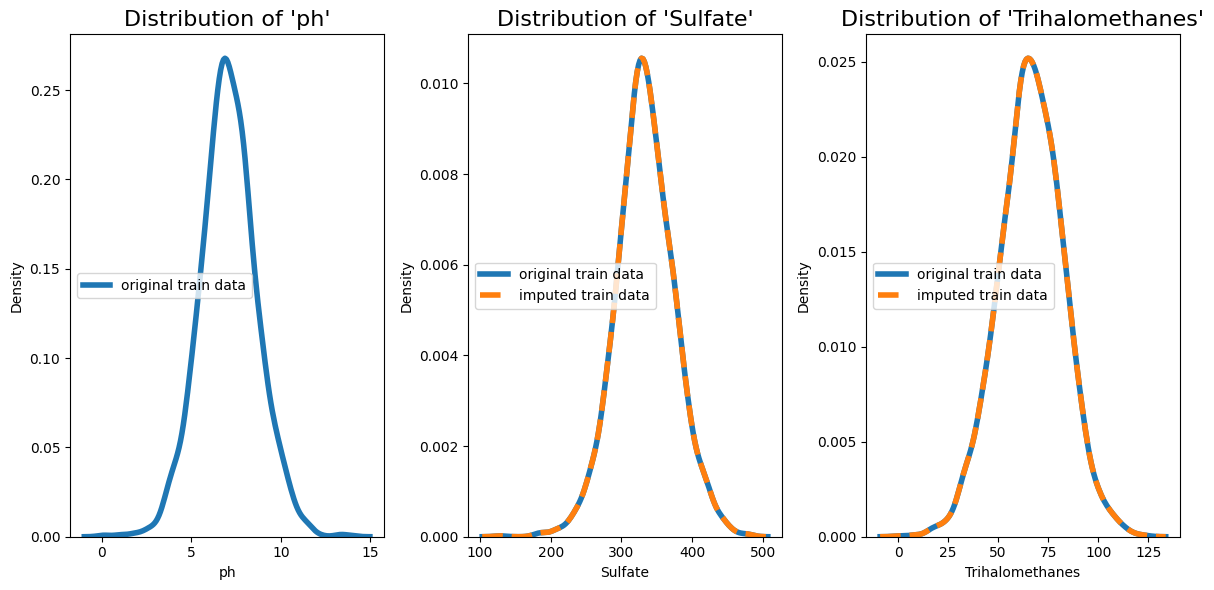

In [20]:
plot_nulls(X, X2)

In [21]:
X3 = X.copy()

imputer3 = ColumnTransformer(
    transformers=[
        ("KNN_imputer", KNNImputer(n_neighbors=5,weights='distance',metric='nan_euclidean',add_indicator=False), predictors)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

imputer3.fit_transform(X3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,7.029862,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,335.429474,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,333.327878,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075
...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821
3272,7.808856,193.553212,17329.802160,8.061362,354.942110,392.449580,19.903225,57.651606,2.798243
3273,9.419510,175.762646,33155.578218,7.350233,326.540813,432.044783,11.039070,69.845400,3.298875
3274,5.126763,230.603758,11983.869376,6.303357,329.684523,402.883113,11.168946,77.488213,4.708658


In [22]:
X4 = X.copy()

preprocessor1 = Pipeline([
    ("mean_imputer", MeanMedianImputer(imputation_method="mean")),
    ('outliers_capping', Winsorizer(variables=predictors, capping_method="iqr", tail="both", fold=1.5)),
    ('scaler', StandardScaler())
    ]).set_output(transform="pandas")

X4 = preprocessor1.fit_transform(X4)

X4.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.000612,0.265461,-0.135691,0.115564,1.093335,1.715401,-1.187299,1.328436,-1.292657
1,-2.309292,-2.091993,-0.387249,-0.315144,-0.000406,2.070162,0.272685,-0.651695,0.687944
2,0.737603,0.869786,-0.238325,1.395235,-0.000406,-0.093403,0.786278,-0.000022,-1.173116
3,0.895116,0.561689,0.007136,0.607257,0.727178,-0.780410,1.263149,2.190618,0.852978
4,1.456334,-0.477657,-0.463030,-0.372561,-0.744666,-0.344116,-0.828861,-2.222985,0.139720


**Classification with a Gradient Boosting Classifier**

In [23]:
X = data.drop('Potability', axis=1)
y = data['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2293, 9), (983, 9), (2293,), (983,))

In [24]:
pipe1 = Pipeline([
    ('preprocessor1', preprocessor1),
    ('rf_classifier', GradientBoostingClassifier(random_state=42))
])

pipe1.fit(X_train, y_train)

print(f'Train accuracy: {pipe1.score(X_train, y_train):.3f}')
print(f'Test accuracy: {pipe1.score(X_test, y_test):.3f}')

Train accuracy: 0.755
Test accuracy: 0.650


In [25]:
y_pred1 = pipe1.predict(X_test)

print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.67      0.88      0.76       617
           1       0.56      0.26      0.36       366

    accuracy                           0.65       983
   macro avg       0.62      0.57      0.56       983
weighted avg       0.63      0.65      0.61       983



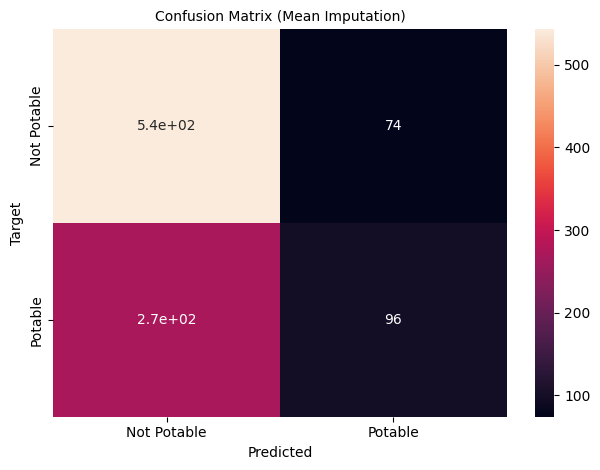

In [26]:
#Generate array of values for confusion matrix
cm = confusion_matrix(y_test, y_pred1)

ax = sns.heatmap(cm, annot=True)
ax.set_title('Confusion Matrix (Mean Imputation)', fontsize=10)
ax.xaxis.set_ticklabels(['Not Potable','Potable'])
ax.yaxis.set_ticklabels(['Not Potable','Potable'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.tight_layout()

In [27]:
preprocessor2 = Pipeline([
    ("random_imputer", RandomSampleImputer(random_state=42)),
    ('outliers_capping', Winsorizer(variables=predictors, capping_method="iqr", tail="both", fold=1.5)),
    ('scaler', StandardScaler())
    ]).set_output(transform="pandas")


pipe2 = Pipeline([
    ('preprocessor2', preprocessor2),
    ('rf_classifier', GradientBoostingClassifier(random_state=42))
])

pipe2.fit(X_train, y_train)

print(f'Train accuracy: {pipe2.score(X_train, y_train):.3f}')
print(f'Test accuracy: {pipe2.score(X_test, y_test):.3f}')

Train accuracy: 0.759
Test accuracy: 0.660


In [28]:
y_pred2 = pipe2.predict(X_test)

print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.67      0.89      0.77       617
           1       0.60      0.27      0.37       366

    accuracy                           0.66       983
   macro avg       0.64      0.58      0.57       983
weighted avg       0.64      0.66      0.62       983



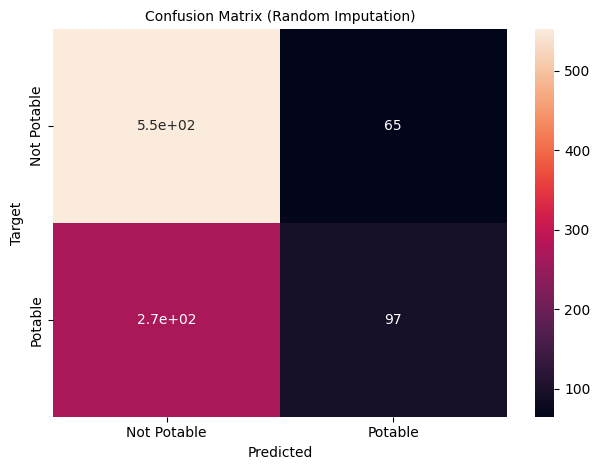

In [29]:
#Generate array of values for confusion matrix
cm = confusion_matrix(y_test, y_pred2)

ax = sns.heatmap(cm, annot=True)
ax.set_title('Confusion Matrix (Random Imputation)', fontsize=10)
ax.xaxis.set_ticklabels(['Not Potable','Potable'])
ax.yaxis.set_ticklabels(['Not Potable','Potable'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.tight_layout()

In [30]:
preprocessor3 = Pipeline([
    ("KNN_imputer", KNNImputer(n_neighbors=5,weights='distance',metric='nan_euclidean',add_indicator=False)),
    ('outliers_capping', Winsorizer(variables=predictors, capping_method="iqr", tail="both", fold=1.5)),
    ('scaler', StandardScaler())
    ]).set_output(transform="pandas")


pipe3 = Pipeline([
    ('preprocessor3', preprocessor3),
    ('rf_classifier', GradientBoostingClassifier(random_state=42))
])

pipe3.fit(X_train, y_train)

print(f'Train accuracy: {pipe3.score(X_train, y_train):.3f}')
print(f'Test accuracy: {pipe3.score(X_test, y_test):.3f}')

Train accuracy: 0.759
Test accuracy: 0.648


In [31]:
y_pred3 = pipe3.predict(X_test)

print(classification_report(y_test, y_pred3))


              precision    recall  f1-score   support

           0       0.67      0.88      0.76       617
           1       0.56      0.26      0.35       366

    accuracy                           0.65       983
   macro avg       0.61      0.57      0.56       983
weighted avg       0.63      0.65      0.61       983



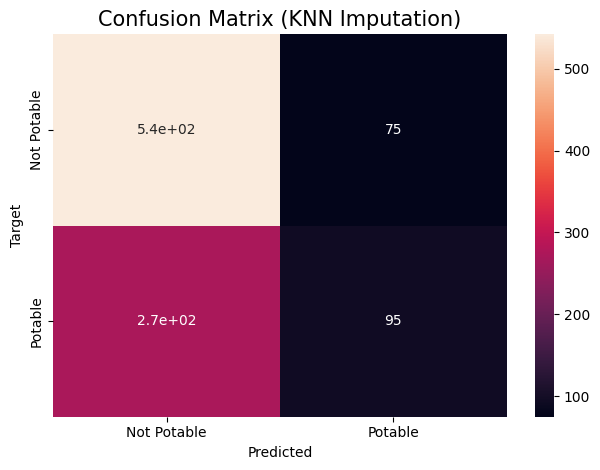

In [32]:
#Generate array of values for confusion matrix
cm = confusion_matrix(y_test, y_pred3)

ax = sns.heatmap(cm, annot=True)
ax.set_title('Confusion Matrix (KNN Imputation)', fontsize=15)
ax.xaxis.set_ticklabels(['Not Potable','Potable'])
ax.yaxis.set_ticklabels(['Not Potable','Potable'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.tight_layout()

In [34]:
# Create a RandomUnderSampler object
rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')

# Balancing the data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [35]:
pipe2.fit(X_resampled, y_resampled)

print(f'Train accuracy: {pipe2.score(X_resampled, y_resampled):.3f}')
print(f'Test accuracy: {pipe2.score(X_test, y_test):.3f}')

Train accuracy: 0.788
Test accuracy: 0.620


In [36]:
y_pred2 = pipe2.predict(X_test)

print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.72      0.65      0.68       617
           1       0.49      0.57      0.53       366

    accuracy                           0.62       983
   macro avg       0.60      0.61      0.60       983
weighted avg       0.63      0.62      0.62       983



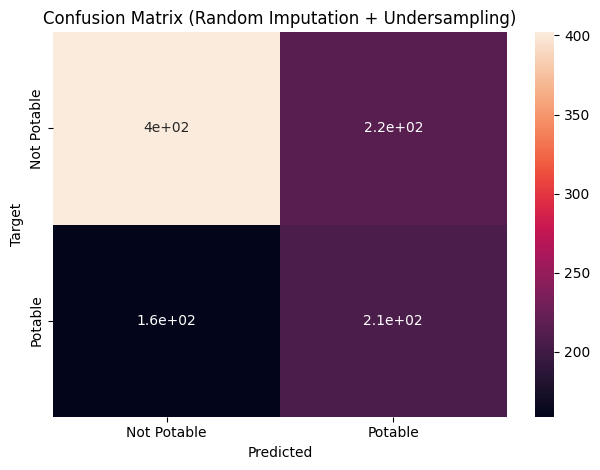

In [37]:
#Generate array of values for confusion matrix
cm = confusion_matrix(y_test, y_pred2)

ax = sns.heatmap(cm, annot=True)
ax.set_title('Confusion Matrix (Random Imputation + Undersampling)', fontsize=12)
ax.xaxis.set_ticklabels(['Not Potable','Potable'])
ax.yaxis.set_ticklabels(['Not Potable','Potable'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.tight_layout()

**Classification with Pytorch**

In [38]:
def return_loaders(X_train, y_train, X_test, y_test, batch_size=16):

    #Preprocess X test and train
    X_train = preprocessor2.fit_transform(X_train)
    X_test  = preprocessor2.transform(X_test)

    #Turn the Xs and ys into tensors
    X_train_tens = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tens = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

    X_test_tens = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tens = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    #Create train and test datasets and dataloaders
    y_train_tens = y_train_tens.unsqueeze(1)
    train_ds = TensorDataset(X_train_tens, y_train_tens)
    train_dl = DataLoader(train_ds, batch_size=batch_size)

    y_test_tens = y_test_tens.unsqueeze(1)
    test_ds = TensorDataset(X_test_tens, y_test_tens)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    #Calculate the input dimensions of the neural network
    n_input_dim = X_train_tens.shape[1]

    return train_dl, test_dl, n_input_dim


train_dl, test_dl, n_input_dim = return_loaders(X_train, y_train, X_test, y_test)

In [39]:
# Layer size
n_hidden = 10  # Number of hidden nodes
n_output =  1  # Number of output nodes

class Model1(nn.Module):

    def __init__(self):
        super(Model1, self).__init__()
        self.layer = nn.Linear(n_input_dim, n_hidden)
        self.layer_out = nn.Linear(n_hidden, n_output)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        x = self.relu(self.layer(inputs))
        x = self.sigmoid(self.layer_out(x))

        return x


model1 = Model1()
print (model1)

Model1(
  (layer): Linear(in_features=9, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [40]:
def train_model(model, train_dl, test_dl, learning_rate=0.001, epochs=500):

    #### Loss Function ####
    loss_func = nn.BCELoss()

    #### Optimizer ####
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #### Train the model ####
    loss_hist_train = [0] * epochs
    loss_hist_test  = [0] * epochs

    for epoch in range(epochs):

        train_loss = 0.
        test_loss  = 0.

        # Loss on the train set
        # Set model to train mode
        model.train()
        for xb, yb in train_dl:
            y_pred = model(xb).unsqueeze(1)    # Forward Propagation
            train_loss = loss_func(y_pred, yb) # Loss Computation
            optimizer.zero_grad()              # Clearing all previous gradients, setting to zero
            train_loss.backward()              # Back Propagation
            optimizer.step()                # Updating the parameters
            loss_hist_train[epoch] += train_loss.item() * yb.size(0)
        loss_hist_train[epoch] /= len(train_dl.dataset)

        # Loss on the test set
        model.eval()
        with torch.no_grad():
            for xbt, ybt in test_dl:
                y_pred_test = model(xbt).unsqueeze(1)
                test_loss = loss_func(y_pred_test, ybt)
                loss_hist_test[epoch] += test_loss.item() * ybt.size(0)
            loss_hist_test[epoch] /= len(test_dl.dataset)

        # Output
        if epoch % 20 == 0:
            print(f'Epoch: {epoch}  Train Loss: {loss_hist_train[epoch]:.3f}  Test Loss: {loss_hist_test[epoch]:.3f}')
     #### Predicting ytest_pred ####
    y_pred_list = []
    model.eval()

    # Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
    # It reduces memory usage and speeds up computation
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            y_test_pred = model(xb_test)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.detach().numpy())

    # Takes arrays and makes them list of list for each batch
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    # Flattens the lists in sequence
    ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

    #### Plotting the train loss and the confusion matrix (test set) ####
    y_true_test = y_test.values.ravel()

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))
     # Plotting the train and test loss
    ax1 = sns.lineplot(loss_hist_train, label='train loss', ax=ax1)
    ax1 = sns.lineplot(loss_hist_test, label='test loss', ax=ax1)
    ax1.set_xlabel('Number of Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Train and Test Loss', size=20)
    # Generate array of values for confusion matrix
    conf_matrix = confusion_matrix(y_true_test, ytest_pred)
    ax2 = sns.heatmap(conf_matrix, annot=True, ax=ax2)
    ax2.set_title('Confusion Matrix (Test Data)', fontsize=15)
    #plt.xaxis.set_ticklabels(['Not Potable','Potable'])
    #plt.yaxis.set_ticklabels(['Not Potable','Potable'])
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("Target")

    plt.tight_layout()

    #### Calculating the accuracy on the test set ####
    print(f'#### Test accuracy = {accuracy_score(y_true_test, ytest_pred):.3f} ####')

Epoch: 0  Train Loss: 0.679  Test Loss: 0.668
Epoch: 20  Train Loss: 0.624  Test Loss: 0.613
Epoch: 40  Train Loss: 0.609  Test Loss: 0.599
Epoch: 60  Train Loss: 0.607  Test Loss: 0.600
Epoch: 80  Train Loss: 0.606  Test Loss: 0.601
#### Test accuracy = 0.679 ####


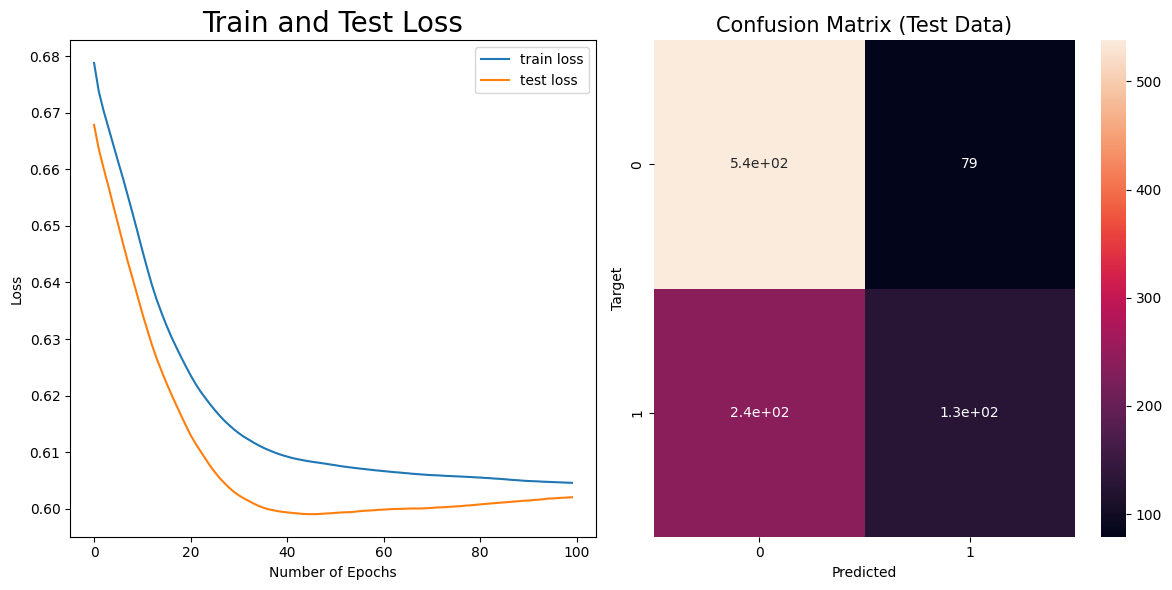

In [41]:
train_model(model1, train_dl, test_dl, epochs=100)

First model classification with undersampled data

Epoch: 0  Train Loss: 0.732  Test Loss: 0.662
Epoch: 20  Train Loss: 0.672  Test Loss: 0.674
Epoch: 40  Train Loss: 0.653  Test Loss: 0.657
Epoch: 60  Train Loss: 0.647  Test Loss: 0.654
Epoch: 80  Train Loss: 0.644  Test Loss: 0.654
#### Test accuracy = 0.617 ####


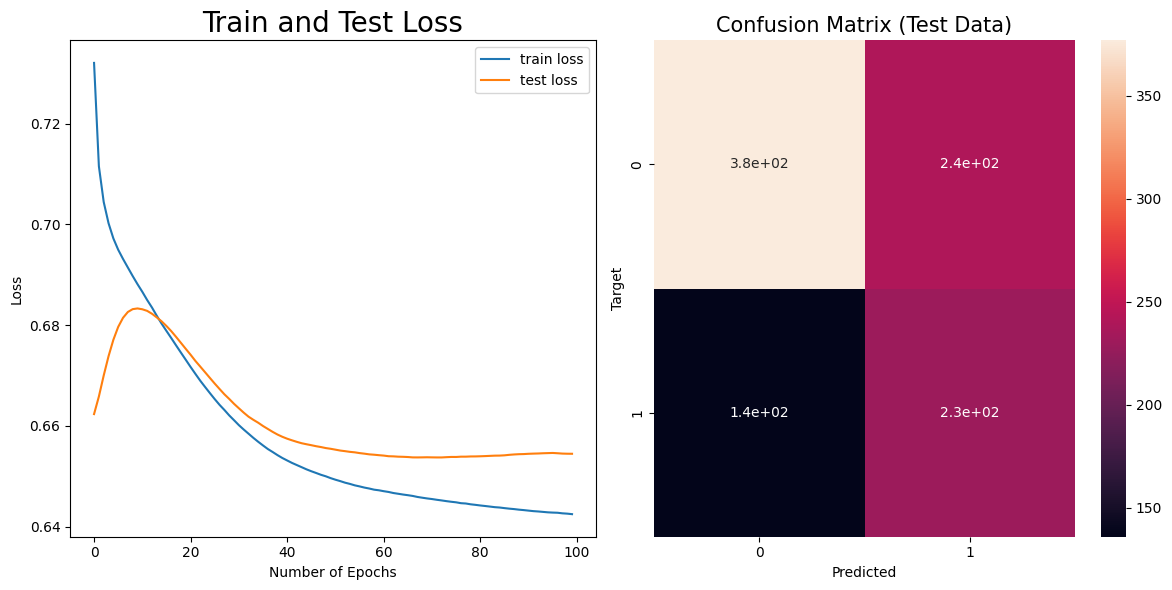

In [42]:
train_dl, test_dl, n_input_dim = return_loaders(X_resampled, y_resampled, X_test, y_test)

model1 = Model1()

train_model(model1, train_dl, test_dl, epochs=100)

Second Model

In [43]:
##Layer Size
n_hidden_1 = 10 # Number of hidden nodes (first layer)
n_hidden_2 = 5  # Number of hidden nodes (second layer)
n_output   = 1  # Number of output nodes

class Model2(nn.Module):

    def __init__(self):
        super(Model2, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden_1)
        self.layer_2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.layer_out = nn.Linear(n_hidden_2, n_output)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))

        return x

model2 = Model2()
print(model2)

Model2(
  (layer_1): Linear(in_features=9, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=5, bias=True)
  (layer_out): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)


Epoch: 0  Train Loss: 0.688  Test Loss: 0.685
Epoch: 20  Train Loss: 0.667  Test Loss: 0.657
Epoch: 40  Train Loss: 0.659  Test Loss: 0.648
Epoch: 60  Train Loss: 0.651  Test Loss: 0.640
Epoch: 80  Train Loss: 0.641  Test Loss: 0.629
Epoch: 100  Train Loss: 0.629  Test Loss: 0.619
Epoch: 120  Train Loss: 0.625  Test Loss: 0.611
Epoch: 140  Train Loss: 0.620  Test Loss: 0.607
Epoch: 160  Train Loss: 0.618  Test Loss: 0.604
Epoch: 180  Train Loss: 0.612  Test Loss: 0.602
Epoch: 200  Train Loss: 0.613  Test Loss: 0.601
Epoch: 220  Train Loss: 0.612  Test Loss: 0.601
Epoch: 240  Train Loss: 0.614  Test Loss: 0.600
Epoch: 260  Train Loss: 0.607  Test Loss: 0.600
Epoch: 280  Train Loss: 0.611  Test Loss: 0.600
#### Test accuracy = 0.688 ####


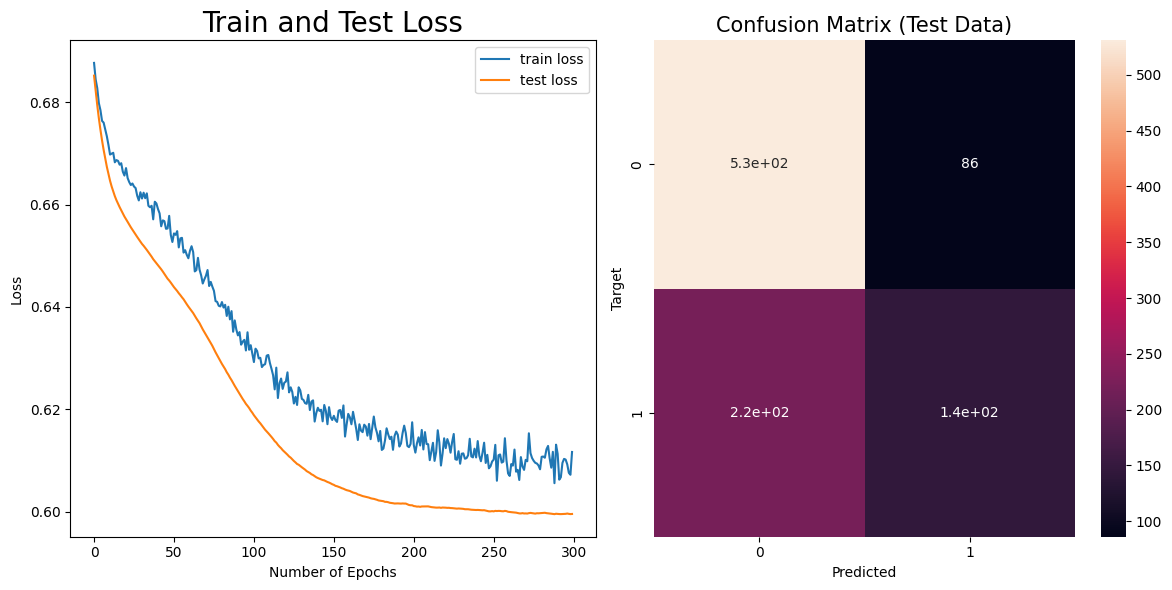

In [44]:
train_dl, test_dl, n_input_dim = return_loaders(X_train, y_train, X_test, y_test)

model2 = Model2()

train_model(model2, train_dl, test_dl, learning_rate=0.0001, epochs=300)

Third Model

In [45]:
n_hidden_1 = 40 # Number of hidden nodes (first layer)
n_hidden_2 = 20 # Number of hidden nodes (second layer)
n_hidden_3 = 10  # Number of hidden nodes (third layer)
n_output   = 1  # Number of output nodes

class Model3(nn.Module):

    def __init__(self):
        super(Model3, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden_1)
        self.layer_2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.layer_3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.layer_out = nn.Linear(n_hidden_3, n_output)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))

        return x


model3 = Model3()
print(model3)

Model3(
  (layer_1): Linear(in_features=9, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)


Epoch: 0  Train Loss: 0.692  Test Loss: 0.687
Epoch: 20  Train Loss: 0.666  Test Loss: 0.654
Epoch: 40  Train Loss: 0.649  Test Loss: 0.631
Epoch: 60  Train Loss: 0.634  Test Loss: 0.615
Epoch: 80  Train Loss: 0.628  Test Loss: 0.607
Epoch: 100  Train Loss: 0.622  Test Loss: 0.604
Epoch: 120  Train Loss: 0.621  Test Loss: 0.603
Epoch: 140  Train Loss: 0.619  Test Loss: 0.602
Epoch: 160  Train Loss: 0.619  Test Loss: 0.601
Epoch: 180  Train Loss: 0.606  Test Loss: 0.600
Epoch: 200  Train Loss: 0.615  Test Loss: 0.600
Epoch: 220  Train Loss: 0.603  Test Loss: 0.600
Epoch: 240  Train Loss: 0.610  Test Loss: 0.599
Epoch: 260  Train Loss: 0.608  Test Loss: 0.599
Epoch: 280  Train Loss: 0.603  Test Loss: 0.600
#### Test accuracy = 0.673 ####


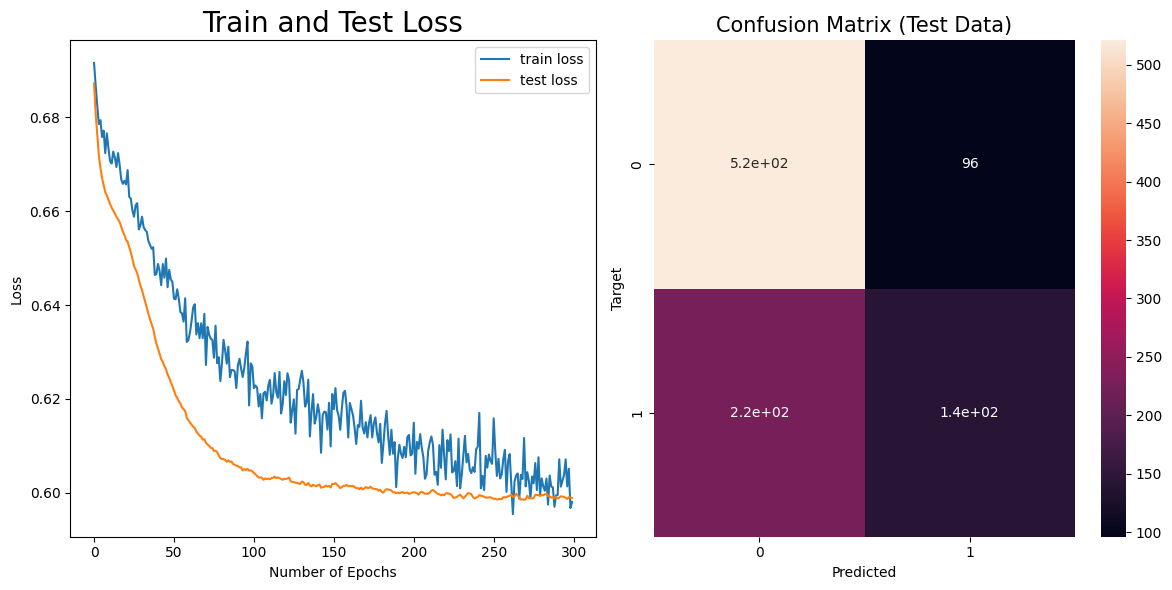

In [46]:
train_dl, test_dl, n_input_dim = return_loaders(X_train, y_train, X_test, y_test)

model3 = Model3()

train_model(model3, train_dl, test_dl, learning_rate=0.0001, epochs=300)